## Import libraries

In [1]:
import scipy
import os
import ast
import glob
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import supervision as sv

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from rad_dino.data.preprocessing import *

## Helper functions

## VinDR-CXR
### Class distribution

In [3]:
CLASS_LABELS = [
      "Aortic enlargement",
      "Atelectasis",
      "Calcification",
      "Cardiomegaly",
      "Consolidation",
      "ILD",
      "Infiltration",
      "Lung Opacity",
      "Nodule/Mass",
      "Other lesion",
      "Pleural effusion",
      "Pleural thickening",
      "Pneumothorax",
      "Pulmonary fibrosis",
      "No finding"
    ]
CLASS2IDX = {c: i for i, c in enumerate(CLASS_LABELS)}

In [8]:
root_folder = "/hpcwork/rwth1833/datasets/VinDr-CXR/download/physionet.org/files/vindr-cxr/1.0.0"
df_train_annot = pd.read_csv(os.path.join(root_folder, "annotations/annotations_train.csv"))
df_train_image_labels = pd.read_csv(os.path.join(root_folder, "annotations/image_labels_train.csv"))
train_filepath = glob.glob(os.path.join(root_folder, "train", '*.dicom'))

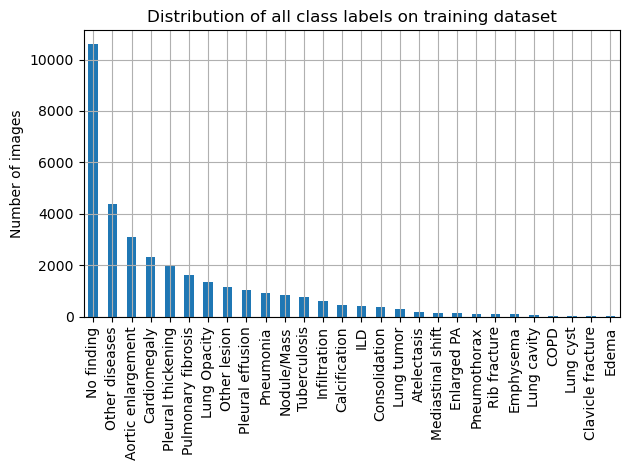

In [9]:
label_cols = [c for c in df_train_image_labels.columns if c not in ("image_id","rad_id")]
by_image = (
    df_train_image_labels
    .groupby("image_id")[label_cols]
    .any()              
    .astype(int)       
)
counts = by_image.sum().sort_values(ascending=False)

plt.figure()
counts.plot(kind="bar")
plt.title("Distribution of all class labels on training dataset")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid()
plt.show()

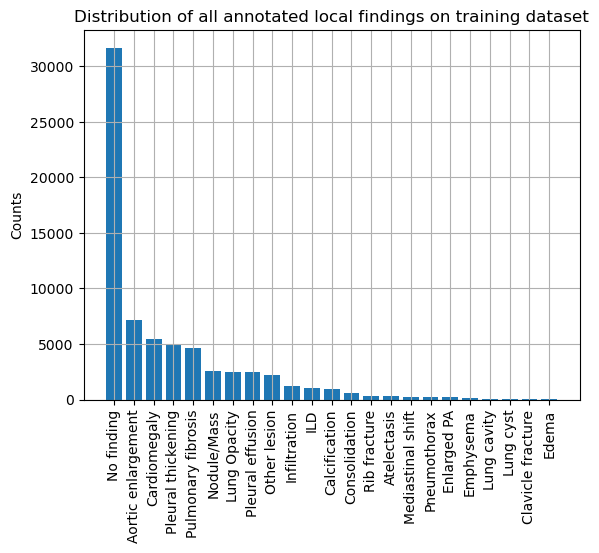

In [10]:
plt.figure()
x = df_train_annot['class_name'].value_counts().keys()
y = df_train_annot['class_name'].value_counts().values
plt.bar(x, y)
plt.xticks(x, rotation=90)
plt.ylabel("Counts")
plt.title("Distribution of all annotated local findings on training dataset")
plt.grid()
plt.show()

### Visualize radiology image

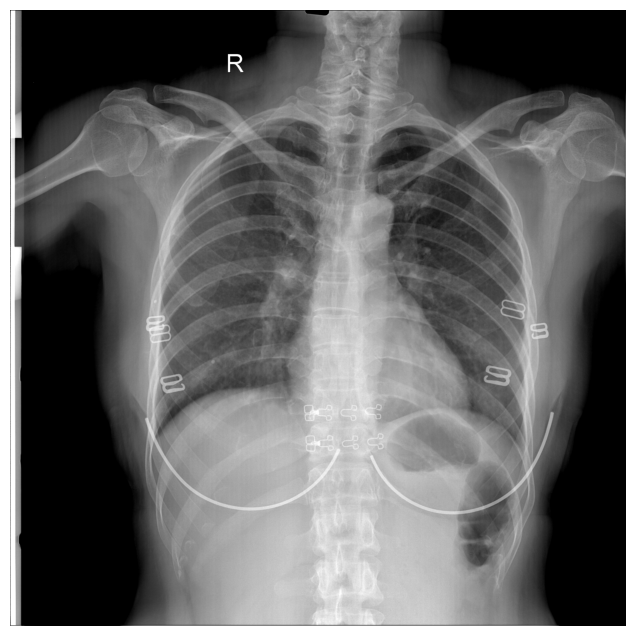

In [11]:
img = dicom2array(train_filepath[0])
plot_image(img, cmap='gray')

### Visualize annotated bounding box

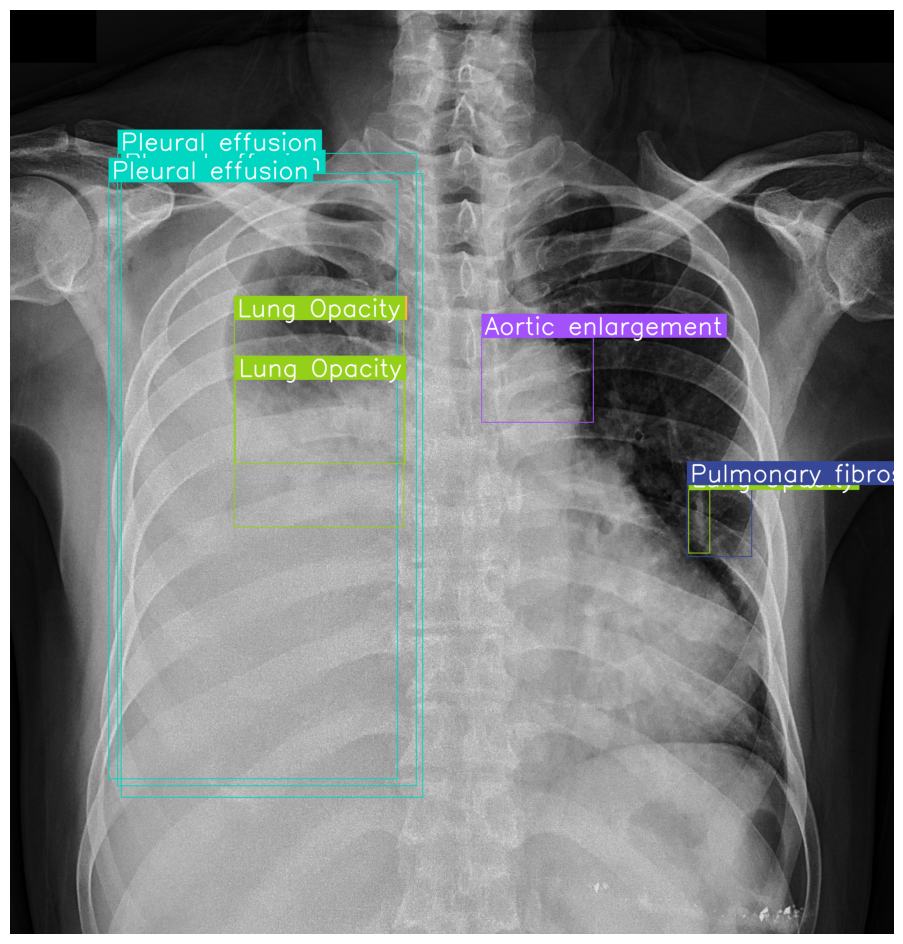

In [12]:
# Load one image and its annotations
image_id = df_train_annot[df_train_annot['class_name']!='No finding']['image_id'].values.tolist()[100]
img = cv2.cvtColor(dicom2array(os.path.join(root_folder, "train", f"{image_id}.dicom")),cv2.COLOR_GRAY2RGB)

# Convert to xyxy and arrays
df_img = df_train_annot[df_train_annot.image_id == image_id]
xyxy = df_img.apply(
    lambda row: [
        row.x_min,
        row.y_min,
        row.x_max,
        row.y_max
    ],
    axis=1,
    result_type="expand"
).to_numpy()

class_names   = df_img.class_name .to_list()
class_ids     = np.array([CLASS2IDX[cls] for cls in class_names]).astype(int)
confidences   = np.ones(len(xyxy), dtype=float)  # no scores in EDA, so set to 1.0

# Create the Detections object
detections = sv.Detections(
    xyxy=xyxy,
    class_id=class_ids,
    confidence=confidences,
    data={"class_name": class_names}
)

# Annotate
box_annotator   = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_scale=2.5, text_thickness=3)

# draw boxes and labels
annotated = box_annotator.annotate(scene=img.copy(), detections=detections)
annotated = label_annotator.annotate(scene=annotated, detections=detections)
sv.plot_image(annotated)

## RSNA-Pneumonia

### Class distribution

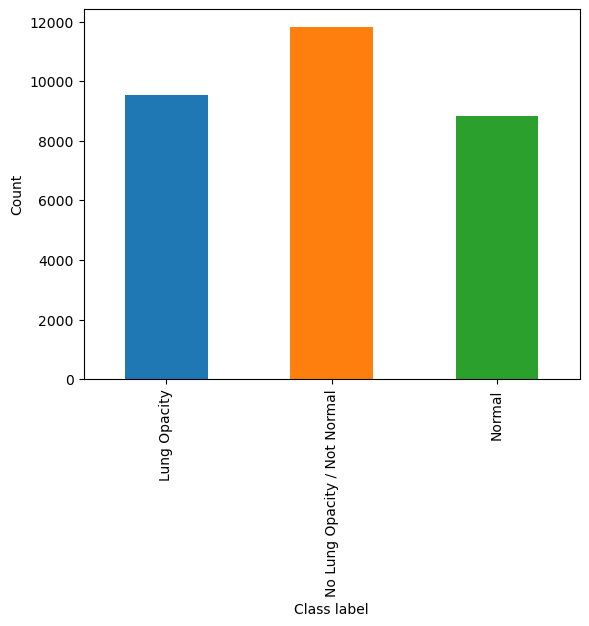

In [3]:
root_folder = "/hpcwork/rwth1833/datasets/RSNA-Pneumonia"
train_filepath = glob.glob(os.path.join(root_folder, "stage_2_train_images", '*.dcm'))
df = pd.read_csv(os.path.join(root_folder, "stage_2_detailed_class_info.csv"))
counts = df.groupby('class').size()
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(len(counts))]  # e.g. [blue, orange, green, …]
counts.plot(kind='bar', color=colors)
plt.xlabel('Class label')
plt.ylabel('Count')
plt.show()

### Visualize radiological image

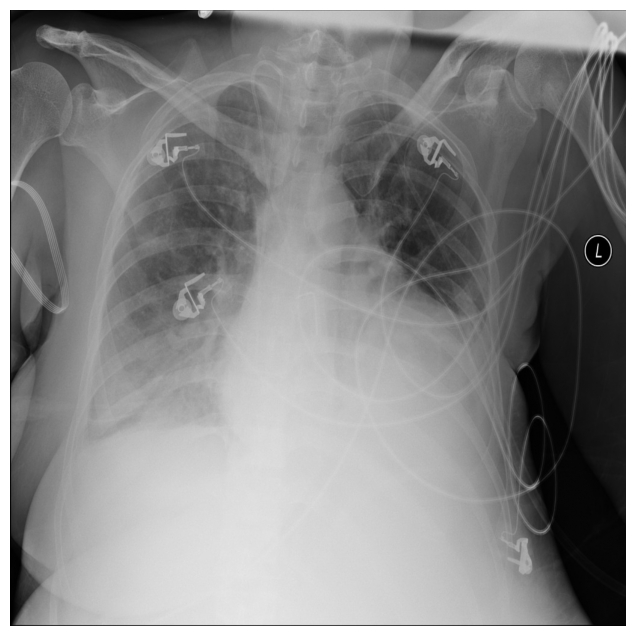

In [4]:
img = dicom2array(train_filepath[0])
plot_image(img, cmap='gray')

### Visualize annotated bounding box

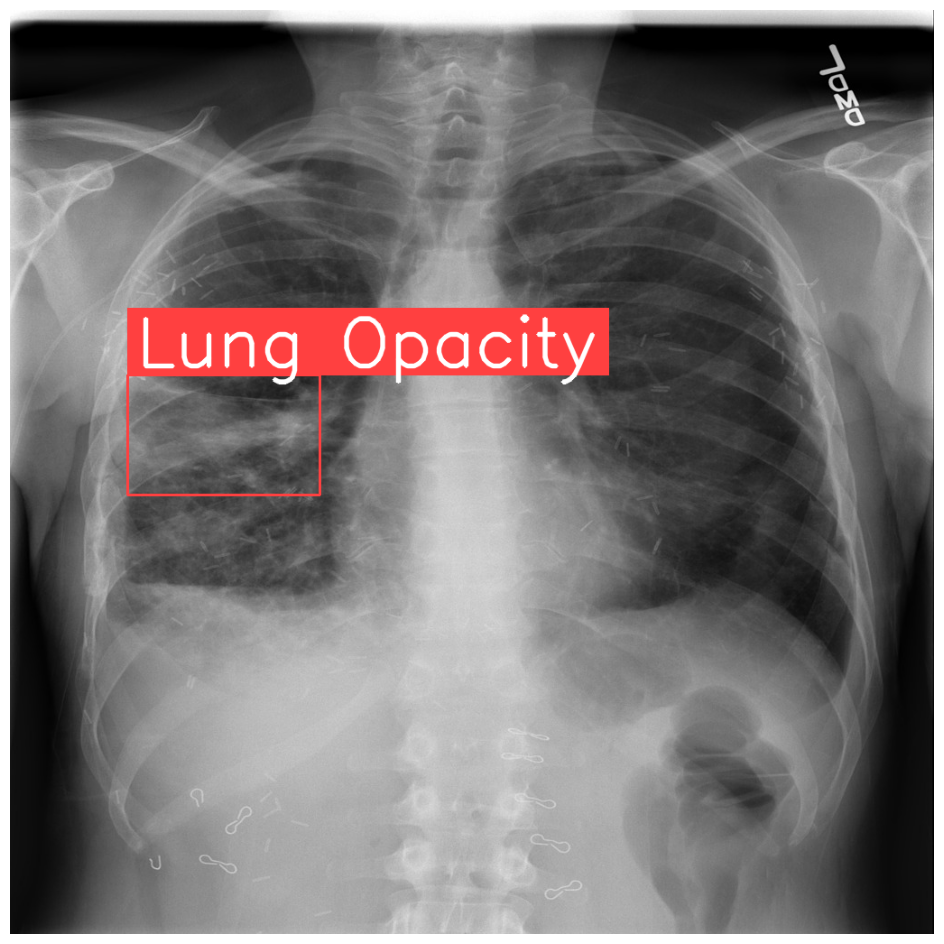

In [22]:
# Load one image and its annotations
image_id = '6df264b0-ab7f-471c-b371-7c4018fb43a4'
df_annot = pd.read_csv(os.path.join(root_folder, "stage_2_train_labels.csv"))
img = cv2.cvtColor(dicom2array(os.path.join(root_folder, "stage_2_train_images", f"{image_id}.dcm")),cv2.COLOR_GRAY2RGB)

# Convert to xyxy and arrays
df_img = df_annot[df_annot.patientId == image_id]
xywh = df_img.apply(
    lambda row: [
        row.x,
        row.y,
        row.width,
        row.height
    ],
    axis=1,
    result_type="expand"
).to_numpy()
xyxy = sv.xywh_to_xyxy(xywh=xywh) # convert to xyxy
class_names   = ["Lung Opacity"]
class_ids     = np.array(df_img.Target.to_list()).astype(int)
confidences   = np.ones(len(xyxy), dtype=float)  # no scores in EDA, so set to 1.0

# Create the Detections object
detections = sv.Detections(
    xyxy=xyxy,
    class_id=class_ids,
    confidence=confidences,
    data={"class_name": class_names}
)

# Annotate
box_annotator   = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_scale=2.5, text_thickness=3)

# draw boxes and labels
annotated = box_annotator.annotate(scene=img.copy(), detections=detections)
annotated = label_annotator.annotate(scene=annotated, detections=detections)
sv.plot_image(annotated)

## VinDr-Mammography

In [32]:
root_folder = "/hpcwork/rwth1833/datasets/VinDr-Mammo/download/physionet.org/files/vindr-mammo/1.0.0"
df = pd.read_csv(os.path.join(root_folder, "finding_annotations.csv"))
df['finding_categories'] = df['finding_categories'].apply(lambda x: ast.literal_eval(x))
def count_class_frequencies(df):
    # Count frequency of each category across all annotations
    category_counts = {}
    for finding_categories in df['finding_categories']:
        for category in finding_categories:
            category_counts[category] = category_counts.get(category, 0) + 1

    # Convert to pandas Series for easier manipulation
    category_freq = pd.Series(category_counts).sort_values(ascending=False)
    return category_freq

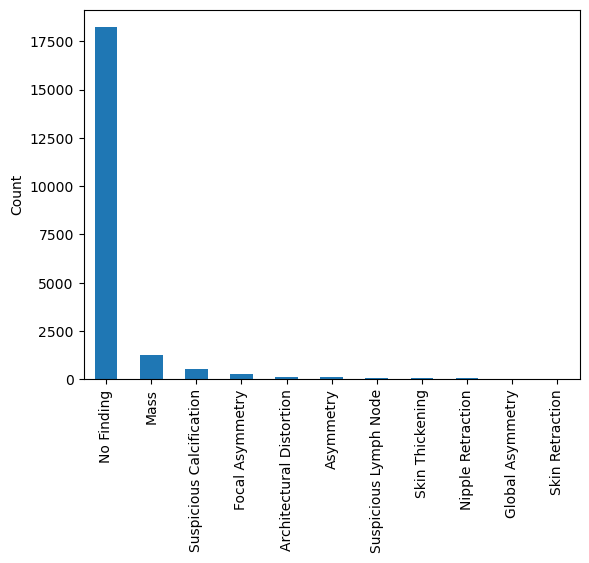

In [30]:
category_freq = count_class_frequencies(df)
category_freq.plot(kind='bar')
plt.ylabel('Count')
plt.show()

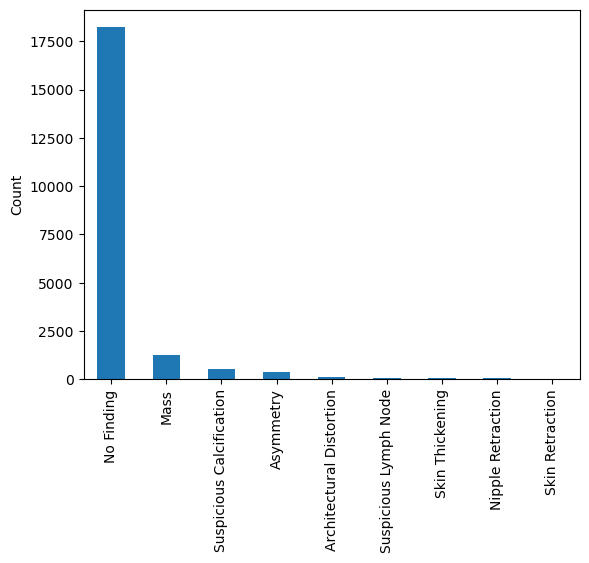

In [31]:
def merge_asymmetry_labels(finding_categories):
    """
    Merge Asymmetry, Global Asymmetry, and Focal Asymmetry into a single 'Asymmetry' label.
    
    Args:
        finding_categories: List of category labels for a single annotation.
    Returns:
        List of category labels with asymmetry variants merged.
    """
    asymmetry_variants = ['Asymmetry', 'Global Asymmetry', 'Focal Asymmetry']
    
    # Check if any asymmetry variant is present
    has_asymmetry = any(variant in finding_categories for variant in asymmetry_variants)
    
    if has_asymmetry:
        # Remove all asymmetry variants
        filtered_categories = [cat for cat in finding_categories if cat not in asymmetry_variants]
        # Add the unified 'Asymmetry' label
        filtered_categories.append('Asymmetry')
        return filtered_categories
    else:
        return finding_categories
df['finding_categories'] = df['finding_categories'].apply(merge_asymmetry_labels)
category_freq = count_class_frequencies(df)
category_freq.plot(kind='bar')
plt.ylabel('Count')
plt.show()

In [33]:
df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,[Mass],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,[Global Asymmetry],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,[Architectural Distortion],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training


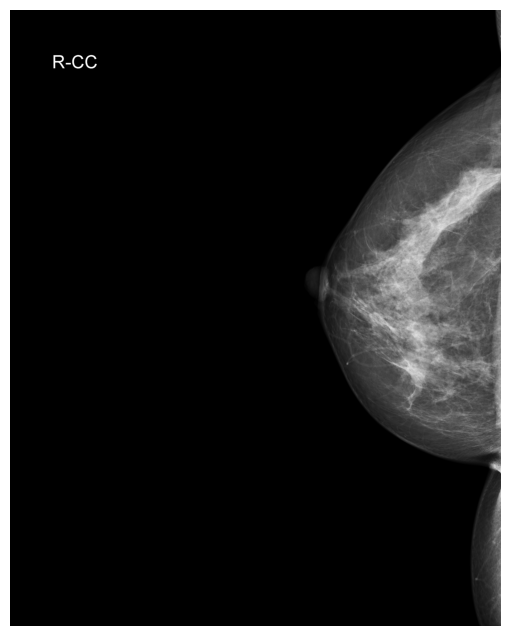

In [37]:
# images/{study_id}/{image_id}.dicom
study_id = df["study_id"][4]
image_id = df["image_id"][4]
src_file = os.path.join(root_folder, f"images/{study_id}/{image_id}.dicom")
img = dicom2array(src_file)
plot_image(img, cmap='gray')